<a href="https://colab.research.google.com/github/HyeJin816/ESSA_22/blob/main/0314_ch3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Ch.3 분류**
#### 0313(월) 과제 : 핸즈온 127~154p

-----  
## **3.1 MNIST**
MNIST : 70,000개의 작은 숫자 이미지 데이터셋

In [2]:
## MNIST 데이터셋 내려받는 코드

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

'data' 샘플이 하나의 행, 특성이 하나의 열로 구성된 배영을 가진 key  
'target' 레이블 배열  
'DESCR' 데이터셋 설명  

In [3]:
X, y = mnist["data"], mnist["target"]

print(X.shape) # 70,000개 이미지, 784개 특성(28*28픽셀)
print(y.shape)

(70000, 784)
(70000,)


<function matplotlib.pyplot.show>

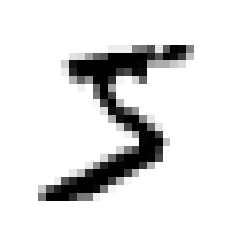

In [6]:
## 이미지 확인

import matplotlib as matplotlib
import matplotlib.pyplot as plt

some_digit = X.to_numpy()[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show

In [8]:
## 실제 레이블 확인

y[0]

'5'

In [10]:
## 문자열을 정수로 변환
import numpy as np
y = y.astype(np.uint8)

## 테스트 세트 생성 (교차검증폴드)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

-----  
## **3.2 이진분류기 훈련**
이진분류기 : '해당 숫자'와 '해당 숫자 아님'의 두 클래스 구분

In [11]:
## 분류를 위한 타킷 벡터 생성

y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

확률적 경사 하강법 (Stochastic Gradient Descent, SGD) : 한번에 하나씩 훈련 샘플을 독립적으로 처리하여 큰 데이터셋을 효율적으로 처리하는 장점. 온라인 학습에 적절.

In [12]:
## SGDClassifier 모델 생성

from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [13]:
## 이미지 감지

sgd_clf.predict([some_digit])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([ True])

-----  
## **3.3 성능 측정**



### **3.3.1 교차 검증을 사용한 정확도 측정**  

사이킷런이 제공하는 기능보다 교차 검증 과정을 더 많이 제어해야할 때 cross_val_score()과 유사하게 수행하도록 검증 기능을 직접 구현함.

In [28]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train.iloc[train_index,:]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train.iloc[test_index,:]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)

  print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적으로 샘플링 수행. 

In [29]:
## 폴드가 3개인 k-겹 교차 검증으로 SGDClassifier 모델 평가

from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

모든 교차 검증 폴드에 대해 정확도 95% 이상.


In [33]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

In [34]:
## 모델 정확도 추측

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

모두 정확도 90% 이상 (= 아님을 예측했을 때의 정확도)

### **3.3.2 오차 행렬**  

오차 행렬 조사 : 분류기의 성능을 평가하는 방법.  
실제 타깃과 비교할 수 있도록 먼저 예측값을 만들어야 함. 테스트 세트가 아닌 cross_val_predict() 함수 사용.

In [36]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

cross_val_predict() 함수는 k교차 검증을 수행하여 각 테스트 폴드 예측을 반환하지만 평가 점수는 반환하지 않음.  
confusion_matrix()로 오차행렬 생성.

In [37]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

음성클래스 : 진짜 음성 53892개, 거짓 양성 687개  
양성클래스 : 거짓 음성 1891개, 진짜 양성 3530개

In [39]:
## 완벽한 분류기
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

정밀도 = (진짜 양성) / (진짜 양성 + 거짓 양성)  
재현율 = (진짜 양성) / (진짜 양성 + 거짓 음성)

### **3.3.3 정밀도와 재현율**  


In [41]:
from sklearn.metrics import precision_score, recall_score

## 정밀도
print( precision_score(y_train_5, y_train_pred) )

## 재현율
print( recall_score(y_train_5, y_train_pred) )

0.8370879772350012
0.6511713705958311


판별된 이미지 중에서 83%만 정확하고, 판별 대상은 65%만 감지.  
> F1 점수 사용 : 정밀도와 재현율의 조화평균  
> f1_score() 호출 

In [42]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

정밀도/재현율 트레이드오프 : 정밀도를 올리면 재현율이 줄고 그 반대도 마찬가지


### **3.3.4 정밀도/재현율 트레이드오프**  

결정 함수를 사용하여 각 샘플의 점수를 계산하고, 그 임계값보다 크면 양성클래스에 할당, 그렇지 않으면 음성클래스에 할당.  
결정 임계값 : 임계값을 높이면 정밀도가 높아지고 재현율이 낮아지며, 임계값을 낮추면 재현율이 높아지고 정밀도가 줄어든다.
> predict() 대신 decision_function()를 사용하면 샘플 점수 확인 가능.
> 이 점수를 기반으로 원하는 임계값을 설정하여 예측 가능.

In [45]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

threshold = 0   # 임계값 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

[2164.22030239]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([ True])

임계값을 0으로 하여 predict()와 값은 결과로 True 반환

In [46]:
threshold = 8000  # 임계값 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

임계값을 높여서 재현율이 감소

In [47]:
## 결정 점수 반환
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method='decision_function')

## 임계값에 대한 정밀도&재현율 계산
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

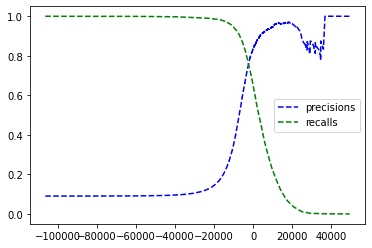

In [50]:
## 맷플롯립으로 임계값 함수 정밀도&재현율 표현

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], 'b--', label='precisions')
  plt.plot(thresholds, recalls[:-1], 'g--', label='recalls')
  plt.legend()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

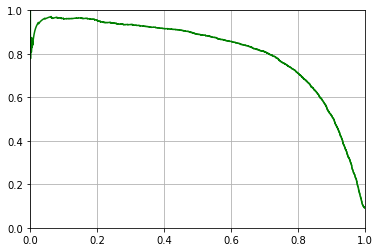

In [54]:
## 재현율에 대한 정밀도 표현

def plot_precision_recall_vs_threshold_2(precisions, recalls, thresholds):
    plt.plot(recalls[:-1], precisions[:-1], 'g-')
    plt.grid()
    plt.xlim(0, 1)
    plt.ylim(0, 1)

plot_precision_recall_vs_threshold_2(precisions, recalls, thresholds)
plt.show()

하강점 직전을 정밀도/재현율 트레이드오프로 선택.

In [56]:
## 정밀도 90% 달성 목표
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

## 분류기 predict() 호출 대신 실행
y_train_pred_90 = (y_scores >= threshold_90_precision)

print('정밀도', precision_score(y_train_5, y_train_pred_90))
print('재현율', recall_score(y_train_5, y_train_pred_90))

정밀도 0.9000345901072293
재현율 0.4799852425751706


### **3.3.5 ROC곡선**  

수신기 조작 특성 (ROC) : 거짓 양성 비율에 대한 진짜 양성 비율의 곡선  
특이도(진짜 음성비율, TNR) = 1- 가짜 음성비율(FNR)
> roc_curve() 함수로 여러 임계값에서 TPR, FPR 계산

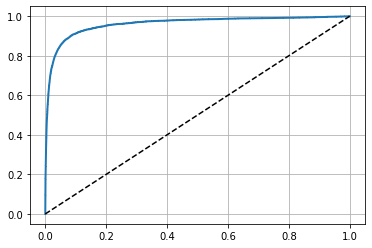

In [58]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

# 맷플로립으로 TPR에 대한 FPR 곡선
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1], [0,1], 'k--')
  plt.grid()

plot_roc_curve(fpr, tpr)
plt.show()

(트레이드오프) 재현율(TPR)이 높을수록 분류기에서 거짓 양성(FPR) 증가. 

In [59]:
## 곡선 아래 면적(AUC) 측정하여 분류기 비교

from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

완벽한 분류기는 AUC가 1이고, 완전한 랜덤 분류기는 AUC가 0.5

In [60]:
## RandomForestClassifier 훈련으로 ROC곡선, ROC AUC 점수 비교

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method='predict_proba')

y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47004 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45924 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54252 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47112 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53944 missing from current font.
  font.set_

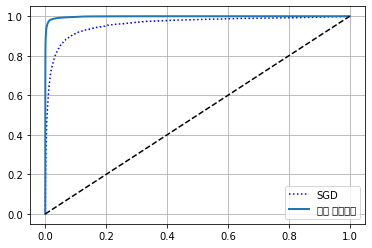

In [62]:
## ROC 곡선 표현

plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, "랜덤 포레스트")
plt.legend(loc='lower right')
plt.show()

RandomForestClassifier의 ROC가 더 왼쪽 모서리 위에 가까워서 SGDClassifier보다 좋다고 판단.

In [63]:
## ROC AUC 점수 확인
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

-----  
## **3.4 다중 분류**

다중분류기 : 둘 이상의 클래스 구별  
OvR 전략 : 이진분류기 여러개를 훈련시키고 분류기의 결정 점수 중에서 가장 높은 것을 선택  
OvO 전략 : 각 대상의 조합마다 이진분류기 훈련. 
> 다중클래스 분류 작업에 사이킷런이 자동으로 실행

In [64]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


array([5], dtype=uint8)

사이킷런이 OvO전략을 사용해서 10개의 이진분류기를 훈련시키고 각각의 결정점수로 최종 클래스 결정.

In [65]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [66]:
print(np.argmax(some_digit_scores))

print(svm_clf.classes_)

print(svm_clf.classes_[5])

5
[0 1 2 3 4 5 6 7 8 9]
5


-----  
## **3.5 에러분석**

오차 행렬을 살펴보기 위해서 cross_val_predict() 함ㅅ를 사용해 예측을 만들고 이전처럼 confusion_matrix() 함수 호출

In [69]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

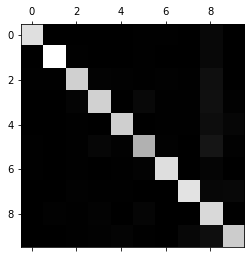

In [70]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

오차 행렬이 주대각선 위에 있어서 대부분의 이미지가 올바르게 분류되어있음. 

In [71]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

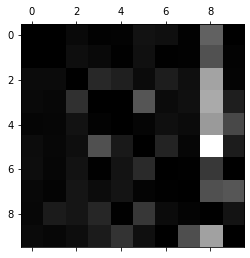

In [73]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

클래스 8이 밝은 것으로 보아 많은 이미지가 8로 잘못 분류됨. 

-----  
## **3.6 다중 레이블 분류**

다중레이블 분류 : 여러개이 이진 꼬리표를 출력하는 분류 시스템

In [75]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train %2 ==1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel) # 2개의 타깃 레이블이 담긴 배열

KNeighborsClassifier()

In [76]:
knn_clf.predict([some_digit])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([[False,  True]])

In [77]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro') # F1 점수 평균 계산

0.976410265560605

가중치 : 레이블에 클래스의 지지도 반영
> average='weighted' 인자 추가

-----  
## **3.7 다중 출력 분류**

다중 출력 다중 클래스 분류 : 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것.  

In [78]:
## 훈련/테스트 세트의 픽셀 강도에 잡음 추가

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise

noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [81]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

KeyError: ignored